In [7]:
!pip install ftfy regex tqdm
!pip install git+https://github.com/openai/CLIP.git
import torch
import clip
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
from tqdm import tqdm

  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-_lbber1g
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-_lbber1g
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done


In [8]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
DEVICE

'cpu'

In [9]:
def load_cub_dataset(data_dir):
    images = pd.read_csv(os.path.join(data_dir, 'images.txt'), sep=' ', names=['image_id', 'file_path'])
    labels = pd.read_csv(os.path.join(data_dir, 'image_class_labels.txt'), sep=' ', names=['image_id', 'class_id'])
    classes = pd.read_csv(os.path.join(data_dir, 'classes.txt'), sep=' ', names=['class_id', 'class_name'])
    bounding_boxes = pd.read_csv(os.path.join(data_dir, 'bounding_boxes.txt'), sep=' ', names=['image_id', 'x', 'y', 'width', 'height'])
    part_locs = pd.read_csv(os.path.join(data_dir, 'parts/part_locs.txt'), sep=' ', names=['img_id', 'part_id', 'x', 'y', 'visible'])
    # parts = pd.read_csv(os.path.join(data_dir, 'parts/parts.txt'), delimiter =' ', names=['part_id', 'part_name'])
    parts = pd.read_fwf(os.path.join(data_dir, 'parts/parts.txt'), colspecs=[(0, 2), (2, None)], header=None, names=['part_id', 'part_name'])
    return images, labels, classes,  bounding_boxes, parts, part_locs
data_dir = '/kaggle/input/cub2002011/CUB_200_2011'
images_dir = os.path.join(data_dir, 'images')
parts_dir = os.path.join(data_dir, 'parts')

images, labels, classes, bounding_boxes, parts, part_locs = load_cub_dataset(data_dir)

print(images.head())
print(labels.head())
print(classes.head())

print(images.shape)
print(labels.shape)
print(classes.shape)

   image_id                                          file_path
0         1  001.Black_footed_Albatross/Black_Footed_Albatr...
1         2  001.Black_footed_Albatross/Black_Footed_Albatr...
2         3  001.Black_footed_Albatross/Black_Footed_Albatr...
3         4  001.Black_footed_Albatross/Black_Footed_Albatr...
4         5  001.Black_footed_Albatross/Black_Footed_Albatr...
   image_id  class_id
0         1         1
1         2         1
2         3         1
3         4         1
4         5         1
   class_id                  class_name
0         1  001.Black_footed_Albatross
1         2        002.Laysan_Albatross
2         3         003.Sooty_Albatross
3         4       004.Groove_billed_Ani
4         5          005.Crested_Auklet
(11788, 2)
(11788, 2)
(200, 2)


In [10]:
clip_model, clip_preprocess = clip.load("ViT-B/32", device=DEVICE, jit=False)
clip_model.eval()

def get_clip_features(img_path):
    img = Image.open(img_path)
    img_input = clip_preprocess(img).unsqueeze(0).to(DEVICE)
    with torch.no_grad():
        img_features = clip_model.encode_image(img_input)
    return img_features

def get_clip_text_features(text):
    text_input = clip.tokenize([text]).to(DEVICE)
    with torch.no_grad():
        text_features = clip_model.encode_text(text_input)
    return text_features

def get_clip_similarity_score(img_features, text_features):
    img_features /= img_features.norm(dim=-1, keepdim=True)
    text_features /= text_features.norm(dim=-1, keepdim=True)
    similarity_score = img_features @ text_features.T
    return similarity_score.item()

def get_cosine_similarity(img_features: torch.Tensor, txt_features: torch.Tensor) -> torch.Tensor:
    """
    Computes the cosine similarity between image and text feature tensors.
    
    Parameters:
    img_features (torch.Tensor): Feature tensor for the image.
    txt_features (torch.Tensor): Feature tensor for the text.

    Returns:
    torch.Tensor: Cosine similarity score between -1 and 1.
    """

    img_features = img_features.squeeze()
    txt_features = txt_features.squeeze()
    
    # Compute dot product
    dot_product = torch.dot(img_features, txt_features)
    
    # Compute L2 norms
    norm_img = torch.norm(img_features, p=2)
    norm_txt = torch.norm(txt_features, p=2)
    
    # Avoid division by zero
    if norm_img == 0 or norm_txt == 0:
        return torch.tensor(0.0)  # Handle zero-vector cases
    
    # Compute cosine similarity
    similarity = dot_product / (norm_img * norm_txt)
    
    return similarity.item()


Class: Black footed Albatross


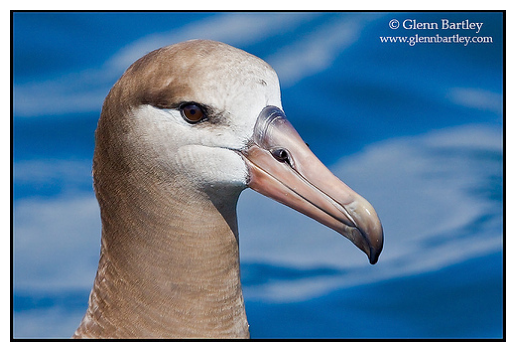

In [11]:
img_id = 1
img_path = os.path.join(images_dir, images[images['image_id'] == img_id]['file_path'].iloc[0])

class_id = labels[labels['image_id'] == img_id]['class_id'].iloc[0]
class_name = " ".join(classes[classes['class_id'] == class_id]['class_name'].iloc[0][4:].split('_'))
print(f'Class: {class_name}')

visible_parts = []
for part in part_locs[part_locs['img_id'] == img_id].itertuples():
    if (part.visible):
        visible_parts.append(parts[parts['part_id'] == part.part_id]['part_name'].iloc[0])
# print(f'Visible parts: {visible_parts}')

image = Image.open(img_path)
plt.imshow(image)
plt.axis('off')
plt.show()

In [13]:
text = "The bird in the picture has a long, curved beak. This beak is likely adapted for catching fish or other aquatic prey. The bird's beak is a prominent feature, and it stands out in the image."
# The bird in the picture has a crown of long, curved beaks.  The bird in the picture has a prominent forehead, which is a noticeable feature of its head.  The bird in the picture has a brown nape.  The right eye of the bird in the picture is open and looking directly at the camera.  The bird in the picture has a long, skinny, and pinkish-colored throat. This distinctive feature is a characteristic of the bird species, which is a seagull. The bird's long beak is also visible in the image, further emphasizing its unique appearance.  The image features a Black-footed Albatross standing on a body of water, possibly the ocean. The bird is looking at the camera, and its beak is open. The environment appears to be a natural habitat for the Albatross, with the water providing a suitable environment for the bird to thrive. The presence of the Albatross in the image suggests that the area is rich in marine life, which is a crucial part of the Albatross's diet."
txt_features = get_clip_text_features(text)
img_features = get_clip_features(img_path)
get_cosine_similarity(img_features, txt_features)

0.26612117886543274